<a href="https://colab.research.google.com/github/pmb-7684/Python-Projects/blob/main/ApSparkByExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!ls

police-station.csv	     spark-2.3.1-bin-hadoop2.7
reported-Chicago-crimes.csv  spark-2.3.1-bin-hadoop2.7.tgz
sample_data		     spark-warehouse


## Install Spark

In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
!tar xf spark-2.3.1-bin-hadoop2.7.tgz
!pip install -q findspark


Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [903 kB]
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [1,100 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-bac

**Create environments for PySpark**

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.1-bin-hadoop2.7"



In [ ]:

import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext.getOrCreate()



In [ ]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate() 
spark

In [ ]:
!wget https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD&bom=true&query=select+*

--2022-08-10 12:24:54--  https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.68.26, 52.206.140.199
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv?accessType=DOWNLOAD’

rows.csv?accessType     [              <=>   ]   1.67G  1.55MB/s    in 11m 14s 

2022-08-10 12:36:11 (2.54 MB/s) - ‘rows.csv?accessType=DOWNLOAD’ saved [1794013622]



In [ ]:
#rename downloaded file
!mv rows.csv\?accessType\=DOWNLOAD reported-Chicago-crimes.csv

In [ ]:
from pyspark.sql.functions import to_timestamp,col,lit
rc = spark.read.csv('reported-Chicago-crimes.csv',header=True).withColumn('Date',to_timestamp(col('Date'),'MM/dd/yyyy hh:mm:ss a')).filter(col('Date') <= lit('2022-01-01'))
rc.show(5)


+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     00

**Shape**

In [ ]:
#curious about shape of data
print((rc.count(), len(rc.columns)))

(7471399, 22)


**Review Data Types or Schemas**

In [ ]:
rc.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Location: string (nullable = true)



In [ ]:
from pyspark.sql.types import StructType, StructType, StringType, TimestampType, BooleanType, DoubleType, IntegerType, StructField

In [ ]:
rc.columns

['ID',
 'Case Number',
 'Date',
 'Block',
 'IUCR',
 'Primary Type',
 'Description',
 'Location Description',
 'Arrest',
 'Domestic',
 'Beat',
 'District',
 'Ward',
 'Community Area',
 'FBI Code',
 'X Coordinate',
 'Y Coordinate',
 'Year',
 'Updated On',
 'Latitude',
 'Longitude',
 'Location']

Below is one way that we can create the structField.  This is one at it time determining the data type and if we are accesing null values.

In [ ]:
'''
StructType([
  Structfield('ID', StringType, True),
  Structfield('Case Number', StringType, True),
  Structfield('Date', TimestampType, True),
  Structfield('Block', StringType, True),
  Structfield('IUCR', StringType, True),
  Structfield('Primary Type', StringType, True),
  Structfield('Description', StringType, True),
  Structfield('Location Description', StringType, True),
  Structfield('Arrest', Boolean, True),
  Structfield('Domestic', StringType, True),
  Structfield('Beat', StringType, True),
  Structfield('District', StringType, True),
  Structfield('Ward', StringType, True),
  Structfield('Community Area', StringType, True),
  Structfield('FBI Code', StringType, True),
  Structfield('X Coordinate', StringType, True),
  Structfield('Y Coordinate', StringType, True),
  Structfield('Year', IntegerType, True),
  Structfield('Updated On', StringType, True),
  Structfield('Latitude', DoubleType, True),
  Structfield('Longitude', DoubleType, True),
  Structfield('Location', StringType, True),
            ])
            '''

"\nStructType([\n  Structfield('ID', StringType, True),\n  Structfield('Case Number', StringType, True),\n  Structfield('Date', TimestampType, True),\n  Structfield('Block', StringType, True),\n  Structfield('IUCR', StringType, True),\n  Structfield('Primary Type', StringType, True),\n  Structfield('Description', StringType, True),\n  Structfield('Location Description', StringType, True),\n  Structfield('Arrest', Boolean, True),\n  Structfield('Domestic', StringType, True),\n  Structfield('Beat', StringType, True),\n  Structfield('District', StringType, True),\n  Structfield('Ward', StringType, True),\n  Structfield('Community Area', StringType, True),\n  Structfield('FBI Code', StringType, True),\n  Structfield('X Coordinate', StringType, True),\n  Structfield('Y Coordinate', StringType, True),\n  Structfield('Year', IntegerType, True),\n  Structfield('Updated On', StringType, True),\n  Structfield('Latitude', DoubleType, True),\n  Structfield('Longitude', DoubleType, True),\n  Struct

A better method is creating structType for our variables by using a list of tuples, and the list conprehension from python.

In [ ]:
labels = [
 ('ID',StringType()),
 ('Case Number', StringType()),
 ('Date',TimestampType()),
 ('Block',StringType()),
 ('IUCR',StringType()),
 ('Primary Type',StringType()),
 ('Description',StringType()),
 ('Location Description',StringType()),
 ('Arrest',StringType()),
 ('Domestic', BooleanType()),
 ('Beat',StringType()),
 ('District',StringType()),
 ('Ward',StringType()),
 ('Community Area',StringType()),
 ('FBI Code',StringType()),
 ('X Coordinate',StringType()),
 ('Y Coordinate',StringType()),
 ('Year', IntegerType()),
 ('Updated On',StringType()),
 ('Latitude', DoubleType()),
 ('Longitude',DoubleType()),
 ('Location',StringType())
 ]

In [ ]:
 schema1 = StructType([StructField (x[0],x[1],True) for x in labels])
 schema1

StructType(List(StructField(ID,StringType,true),StructField(Case Number,StringType,true),StructField(Date,TimestampType,true),StructField(Block,StringType,true),StructField(IUCR,StringType,true),StructField(Primary Type,StringType,true),StructField(Description,StringType,true),StructField(Location Description,StringType,true),StructField(Arrest,StringType,true),StructField(Domestic,BooleanType,true),StructField(Beat,StringType,true),StructField(District,StringType,true),StructField(Ward,StringType,true),StructField(Community Area,StringType,true),StructField(FBI Code,StringType,true),StructField(X Coordinate,StringType,true),StructField(Y Coordinate,StringType,true),StructField(Year,IntegerType,true),StructField(Updated On,StringType,true),StructField(Latitude,DoubleType,true),StructField(Longitude,DoubleType,true),StructField(Location,StringType,true)))

In [ ]:
rc = spark.read.csv('reported-Chicago-crimes.csv', schema = schema1)
rc.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



In [ ]:
rc.show(5)

+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     00

**Row and Column**

In [ ]:
rc.select('Description').show(5)

+--------------------+
|         Description|
+--------------------+
|DOMESTIC BATTERY ...|
|      POCKET-PICKING|
|           OVER $500|
|POSS: HEROIN(BRN/...|
|              SIMPLE|
+--------------------+
only showing top 5 rows



In [ ]:
rc.select(rc.Description).show(5)

+--------------------+
|         Description|
+--------------------+
|DOMESTIC BATTERY ...|
|      POCKET-PICKING|
|           OVER $500|
|POSS: HEROIN(BRN/...|
|              SIMPLE|
+--------------------+
only showing top 5 rows



In [ ]:
rc.select(col('Description')).show(5)

+--------------------+
|         Description|
+--------------------+
|DOMESTIC BATTERY ...|
|      POCKET-PICKING|
|           OVER $500|
|POSS: HEROIN(BRN/...|
|              SIMPLE|
+--------------------+
only showing top 5 rows



In [ ]:
rc.select('Case Number', 'Date', 'Arrest', 'Description').show(5)

+-----------+-------------------+------+--------------------+
|Case Number|               Date|Arrest|         Description|
+-----------+-------------------+------+--------------------+
|   HY411648|2015-09-05 13:30:00| false|DOMESTIC BATTERY ...|
|   HY411615|2015-09-04 11:30:00| false|      POCKET-PICKING|
|   JC213529|2018-09-01 00:01:00| false|           OVER $500|
|   HY411595|2015-09-05 12:45:00|  true|POSS: HEROIN(BRN/...|
|   HY411610|2015-09-05 13:00:00| false|              SIMPLE|
+-----------+-------------------+------+--------------------+
only showing top 5 rows



In [ ]:
# use lit to add column(s) to a dataframe
from pyspark.sql.functions import lit

In [ ]:
rc.withColumn('Info', lit(1)).show(5)

+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+----+
|      ID|Case Number|               Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|Info|
+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+----+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    tr

In [ ]:
#remove a column from the data
rc.drop("Info")
rc.show(5)

+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     00

In [ ]:
#double check my filter; it seems 01.01.2022 is not included in the rc dataset.
rc.withColumn('Date',to_timestamp(col('Date'),'MM/dd/yyyy hh:mm:ss a')).filter(col('Date') == '2022-01-01').show(5)

+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+--------+---------+--------+
| ID|Case Number|Date|Block|IUCR|Primary Type|Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|Updated On|Latitude|Longitude|Location|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+--------+---------+--------+
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+--------+---------+--------+



In [ ]:
# add the reported crimes for an additional day. First pull crimes from 01.01.2022
one_day = spark.read.csv('reported-Chicago-crimes.csv',header=True).withColumn('Date',to_timestamp(col('Date'),'MM/dd/yyyy hh:mm:ss a')).filter(col('Date') == lit('2022-01-01'))
one_day.count()


80

In [ ]:
one_day.show(7)

+--------+-----------+-------------------+--------------------+----+---------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|   Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+---------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|12583059|   JF101544|2022-01-01 00:00:00|  020XX N KARLOV AVE|0820|          THEFT|      $500 AND UNDER|              STREET| false|   false|

In [ ]:
rc.union(one_day).orderBy('Date', ascending=False).show(5)

+--------+-----------+-------------------+--------------------+----+---------------+--------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|   Primary Type|   Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+---------------+--------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|12582404|   JF100769|2022-01-01 00:00:00|115XX S EGGLESTON...|1310|CRIMINAL DAMAGE|   TO PROPERTY|           RESIDENCE| false|   false|0522|     005|  34|     

In [ ]:
#reported crimes by primary tye in descending order
rc.groupBy('Primary type').count().show()

+--------------------+-------+
|        Primary type|  count|
+--------------------+-------+
|OFFENSE INVOLVING...|  52982|
|CRIMINAL SEXUAL A...|   4511|
|            STALKING|   4210|
|PUBLIC PEACE VIOL...|  51375|
|           OBSCENITY|    756|
|NON-CRIMINAL (SUB...|      9|
|               ARSON|  12698|
|   DOMESTIC VIOLENCE|      1|
|            GAMBLING|  14607|
|   CRIMINAL TRESPASS| 208644|
|             ASSAULT| 480293|
|      NON - CRIMINAL|     38|
|LIQUOR LAW VIOLATION|  14643|
| MOTOR VEHICLE THEFT| 345116|
|               THEFT|1572030|
|             BATTERY|1369921|
|             ROBBERY| 280711|
|            HOMICIDE|  11665|
|           RITUALISM|     24|
|    PUBLIC INDECENCY|    188|
+--------------------+-------+
only showing top 20 rows



In [ ]:
#top 10 number of reported crimed by primary tye in descending order
rc.groupBy('Primary type').count().orderBy('count', ascending=False).show(10)

+-------------------+-------+
|       Primary type|  count|
+-------------------+-------+
|              THEFT|1572030|
|            BATTERY|1369921|
|    CRIMINAL DAMAGE| 851657|
|          NARCOTICS| 741016|
|            ASSAULT| 480293|
|      OTHER OFFENSE| 464396|
|           BURGLARY| 414645|
|MOTOR VEHICLE THEFT| 345116|
| DECEPTIVE PRACTICE| 323402|
|            ROBBERY| 280711|
+-------------------+-------+
only showing top 10 rows



In [ ]:
#top 3 location (by description) for reported crimes
rc.groupBy('Location Description').count().orderBy('count',ascending = False).show(4)

+--------------------+-------+
|Location Description|  count|
+--------------------+-------+
|              STREET|1937446|
|           RESIDENCE|1265849|
|           APARTMENT| 819416|
|            SIDEWALK| 713729|
+--------------------+-------+
only showing top 4 rows



In [ ]:
rc.select('Arrest').distinct().show()

+------+
|Arrest|
+------+
| false|
|  true|
+------+



In [ ]:
# percentage of reported crimes that resulted in an arrest
rc.filter(col('Arrest') == 'true').count() / rc.select('Arrest').count()


0.26739664151251996

**Functions**

**Built in functions**

In [ ]:
from pyspark.sql import functions

In [ ]:
print(dir(functions))

['AutoBatchedSerializer', 'Column', 'DataFrame', 'DataType', 'PandasUDFType', 'PickleSerializer', 'PythonEvalType', 'SparkContext', 'StringType', 'UserDefinedFunction', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_binary_mathfunctions', '_collect_list_doc', '_collect_set_doc', '_create_binary_mathfunction', '_create_function', '_create_udf', '_create_window_function', '_functions', '_functions_1_4', '_functions_1_6', '_functions_2_1', '_functions_deprecated', '_lit_doc', '_message', '_string_functions', '_test', '_to_java_column', '_to_seq', '_window_functions', '_wrap_deprecated_function', 'abs', 'acos', 'add_months', 'approxCountDistinct', 'approx_count_distinct', 'array', 'array_contains', 'asc', 'ascii', 'asin', 'atan', 'atan2', 'avg', 'base64', 'bin', 'bitwiseNOT', 'blacklist', 'broadcast', 'bround', 'cbrt', 'ceil', 'coalesce', 'col', 'collect_list', 'collect_set', 'column', 'concat', 'concat_ws', 'conv', 'c

**string functions**

In [ ]:
from pyspark.sql.functions import lower, upper, substring

In [ ]:
help(substring)

Help on function substring in module pyspark.sql.functions:

substring(str, pos, len)
    Substring starts at `pos` and is of length `len` when str is String type or
    returns the slice of byte array that starts at `pos` in byte and is of length `len`
    when str is Binary type.
    
    .. note:: The position is not zero based, but 1 based index.
    
    >>> df = spark.createDataFrame([('abcd',)], ['s',])
    >>> df.select(substring(df.s, 1, 2).alias('s')).collect()
    [Row(s='ab')]
    
    .. versionadded:: 1.5



In [ ]:
rc.select(lower(col('Primary Type')), upper(col('Primary Type')), substring(col('Primary Type'), 1,4)).show(5)

+-------------------+-------------------+-----------------------------+
|lower(Primary Type)|upper(Primary Type)|substring(Primary Type, 1, 4)|
+-------------------+-------------------+-----------------------------+
|            battery|            BATTERY|                         BATT|
|              theft|              THEFT|                         THEF|
|              theft|              THEFT|                         THEF|
|          narcotics|          NARCOTICS|                         NARC|
|            assault|            ASSAULT|                         ASSA|
+-------------------+-------------------+-----------------------------+
only showing top 5 rows



**Numeric functions**

In [ ]:
from pyspark.sql.functions import min, max

In [ ]:
rc.select(min(col('Date')), max(col("Date"))).show(1)

+-------------------+-------------------+
|          min(Date)|          max(Date)|
+-------------------+-------------------+
|2001-01-01 00:00:00|2021-12-31 23:59:00|
+-------------------+-------------------+



**Date**

In [ ]:
from pyspark.sql.functions import date_add, date_sub

In [ ]:
help(date_add)

Help on function date_add in module pyspark.sql.functions:

date_add(start, days)
    Returns the date that is `days` days after `start`
    
    >>> df = spark.createDataFrame([('2015-04-08',)], ['dt'])
    >>> df.select(date_add(df.dt, 1).alias('next_date')).collect()
    [Row(next_date=datetime.date(2015, 4, 9))]
    
    .. versionadded:: 1.5



In [ ]:
rc.select(date_sub(min(col('Date')),3), date_add(max(col('Date')),3)).show(1)

+----------------------+----------------------+
|date_sub(min(Date), 3)|date_add(max(Date), 3)|
+----------------------+----------------------+
|            2000-12-29|            2022-01-03|
+----------------------+----------------------+



**Working with Dates**

In [ ]:
from pyspark.sql.functions import to_date, to_timestamp, lit

In [ ]:
# 2019-12-25 13:30:00
df = spark.createDataFrame([('2019-12-25 13:30:00',)],['Christmas'])
df.show(1)

+-------------------+
|          Christmas|
+-------------------+
|2019-12-25 13:30:00|
+-------------------+



In [ ]:
df.select(to_date(col('Christmas'), 'yyyy-MM-dd HH:mm:ss'), to_timestamp(col('Christmas'), 'yyyy-MM-dd HH:mm:ss')).show(1)

+-------------------------------------------+------------------------------------------------+
|to_date(`Christmas`, 'yyyy-MM-dd HH:mm:ss')|to_timestamp(`Christmas`, 'yyyy-MM-dd HH:mm:ss')|
+-------------------------------------------+------------------------------------------------+
|                                 2019-12-25|                             2019-12-25 13:30:00|
+-------------------------------------------+------------------------------------------------+



In [ ]:
# 25/Dec/2019 13:30:00
df=spark.createDataFrame([('25/Dec/2019 13:30:00',)],['Christmas'])
df.show(1)

+--------------------+
|           Christmas|
+--------------------+
|25/Dec/2019 13:30:00|
+--------------------+



In [ ]:
df.select(to_date(col('Christmas'), 'dd/MMM/yyyy HH:mm:ss'), to_timestamp(col('Christmas'), 'dd/MMM/yyyy HH:mm:ss')).show(1)

+--------------------------------------------+-------------------------------------------------+
|to_date(`Christmas`, 'dd/MMM/yyyy HH:mm:ss')|to_timestamp(`Christmas`, 'dd/MMM/yyyy HH:mm:ss')|
+--------------------------------------------+-------------------------------------------------+
|                                  2019-12-25|                              2019-12-25 13:30:00|
+--------------------------------------------+-------------------------------------------------+



In [ ]:
#12/25/2019 13:30:00

In [ ]:
df = spark.createDataFrame([('12/25/2019 01:30:00 PM',)], ['Christmas'])
df.show(1, truncate=False)

+----------------------+
|Christmas             |
+----------------------+
|12/25/2019 01:30:00 PM|
+----------------------+



In [ ]:
df.select(to_date(col('Christmas'), 'MM/dd/yyyy hh:mm:ss aa'), to_timestamp(col('Christmas'), 'MM/dd/yyyy hh:mm:ss aa')).show(1)

+----------------------------------------------+---------------------------------------------------+
|to_date(`Christmas`, 'MM/dd/yyyy hh:mm:ss aa')|to_timestamp(`Christmas`, 'MM/dd/yyyy hh:mm:ss aa')|
+----------------------------------------------+---------------------------------------------------+
|                                    2019-12-25|                                2019-12-25 13:30:00|
+----------------------------------------------+---------------------------------------------------+



In [ ]:
nrc = spark.read.csv('reported-Chicago-crimes.csv', header = True)
nrc.show(7, truncate=False)

+--------+-----------+----------------------+---------------------+----+------------+-----------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------------------+------------+-------------+-----------------------------+
|ID      |Case Number|Date                  |Block                |IUCR|Primary Type|Description            |Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|Updated On            |Latitude    |Longitude    |Location                     |
+--------+-----------+----------------------+---------------------+----+------------+-----------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------------------+------------+-------------+-----------------------------+
|10224738|HY411648   |09/05/2015 01:30:00 PM|043XX S WOOD ST      |0486|BATTERY     |DOMESTIC BAT

**JOINS**

**Download plice station data**

In [ ]:
!wget -O police-station.csv https://data.cityofchicago.org/api/views/z8bn-74gv/rows.csv?accessType=DOWNLOAD

--2022-08-10 15:52:05--  https://data.cityofchicago.org/api/views/z8bn-74gv/rows.csv?accessType=DOWNLOAD
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.68.26, 52.206.140.199
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘police-station.csv’

police-station.csv      [ <=>                ]   5.57K  --.-KB/s    in 0s      

2022-08-10 15:52:06 (516 MB/s) - ‘police-station.csv’ saved [5699]



In [ ]:
!ls -l

total 1972584
-rw-r--r--  1 root root       5699 Aug 19  2019 police-station.csv
-rw-r--r--  1 root root 1794013622 Aug 10 10:56 reported-Chicago-crimes.csv
drwxr-xr-x  1 root root       4096 Aug  3 20:21 sample_data
drwxrwxr-x 13 1000 1000       4096 Jun  1  2018 spark-2.3.1-bin-hadoop2.7
-rw-r--r--  1 root root  225883783 Jun  1  2018 spark-2.3.1-bin-hadoop2.7.tgz
drwxr-xr-x  2 root root       4096 Aug 10 12:38 spark-warehouse


In [ ]:
ps = spark.read.csv('police-station.csv', header= True)
ps.show(5)

+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+
|    DISTRICT|DISTRICT NAME|            ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION|
+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+
|Headquarters| Headquarters|3510 S Michigan Ave|Chicago|   IL|60653|http://home.chica...|        null|        null|        null| 1177731.401| 1881697.404|41.83070169|-87.62339535|(41.8307016873, -...|
|          18|   Near North| 1160 N Larrabee St|Chicago|   IL|60610|http://home.chica...|312-742-5870|312-742-5771|312-742-5773| 1172080.029| 1908086.527|41.90324165|-87.64335214|(41.9032416531, -

Add district name by joining ps and rc datasets

In [ ]:
#cache to rc dataframe
rc.cache()
rc.count()

7471399

In [ ]:
ps.select(col('District')).distinct().show()

+------------+
|    District|
+------------+
|           7|
|          15|
|          11|
|           3|
|           8|
|          22|
|          16|
|           5|
|          18|
|          17|
|           6|
|          19|
|          25|
|Headquarters|
|          24|
|           9|
|           1|
|          20|
|          10|
|           4|
+------------+
only showing top 20 rows



In [ ]:
rc.select(col('District')).distinct().show()

+--------+
|District|
+--------+
|     009|
|     012|
|      16|
|     024|
|    null|
|     031|
|     015|
|     006|
|     019|
|     020|
|     011|
|     025|
|     005|
|     003|
|     016|
|     018|
|     008|
|     022|
|     001|
|     014|
+--------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import lpad

In [ ]:
help(lpad)

Help on function lpad in module pyspark.sql.functions:

lpad(col, len, pad)
    Left-pad the string column to width `len` with `pad`.
    
    >>> df = spark.createDataFrame([('abcd',)], ['s',])
    >>> df.select(lpad(df.s, 6, '#').alias('s')).collect()
    [Row(s='##abcd')]
    
    .. versionadded:: 1.5



In [ ]:
ps.select(lpad(col('DISTRICT'),3,'0')).show()

+--------------------+
|lpad(DISTRICT, 3, 0)|
+--------------------+
|                 Hea|
|                 018|
|                 019|
|                 020|
|                 022|
|                 024|
|                 025|
|                 001|
|                 002|
|                 003|
|                 004|
|                 005|
|                 006|
|                 007|
|                 008|
|                 009|
|                 010|
|                 011|
|                 012|
|                 ",C|
+--------------------+
only showing top 20 rows



In [ ]:
ps = ps.withColumn('Format_District', lpad(col('DISTRICT'),3,'0'))
ps.show(5)

+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+---------------+
|    DISTRICT|DISTRICT NAME|            ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION|Format_District|
+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+---------------+
|Headquarters| Headquarters|3510 S Michigan Ave|Chicago|   IL|60653|http://home.chica...|        null|        null|        null| 1177731.401| 1881697.404|41.83070169|-87.62339535|(41.8307016873, -...|            Hea|
|          18|   Near North| 1160 N Larrabee St|Chicago|   IL|60610|http://home.chica...|312-742-5870|312-742-5771|312-742-5773| 117

In [ ]:
rc.join(ps, rc.District == ps.Format_District, 'left_outer').show()

+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+--------+--------------+--------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+---------------+
|      ID|Case Number|               Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|DISTRICT| DISTRICT NAME|             ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION|Format_Distri

In [ ]:
ps.columns

['DISTRICT',
 'DISTRICT NAME',
 'ADDRESS',
 'CITY',
 'STATE',
 'ZIP',
 'WEBSITE',
 'PHONE',
 'FAX',
 'TTY',
 'X COORDINATE',
 'Y COORDINATE',
 'LATITUDE',
 'LONGITUDE',
 'LOCATION',
 'Format_District']

In [ ]:
rc.join(ps, rc.District == ps.Format_District, 'left_outer').drop(
 'ADDRESS',
 'CITY',
 'STATE',
 'ZIP',
 'WEBSITE',
 'PHONE',
 'FAX',
 'TTY',
 'X COORDINATE',
 'Y COORDINATE',
 'LATITUDE',
 'LONGITUDE',
 'LOCATION',
).show()

+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+----+--------------------+--------+--------------+---------------+
|      ID|Case Number|               Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|Year|          Updated On|DISTRICT| DISTRICT NAME|Format_District|
+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+----+--------------------+--------+--------------+---------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|           BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     009|  12|            61|     08B|2015|02/10/2018 03:50:...|       9|       Deeri

most frequent reported noncriminal activity

In [ ]:
rc.columns

['ID',
 'Case Number',
 'Date',
 'Block',
 'IUCR',
 'Primary Type',
 'Description',
 'Location Description',
 'Arrest',
 'Domestic',
 'Beat',
 'District',
 'Ward',
 'Community Area',
 'FBI Code',
 'X Coordinate',
 'Y Coordinate',
 'Year',
 'Updated On',
 'Latitude',
 'Longitude',
 'Location']

In [ ]:
rc.select(col('Primary Type')).distinct().count()

36

In [ ]:
rc.select(col('Primary Type')).distinct().orderBy(col('Primary Type')).show(35,truncate=False)

+---------------------------------+
|Primary Type                     |
+---------------------------------+
|ARSON                            |
|ASSAULT                          |
|BATTERY                          |
|BURGLARY                         |
|CONCEALED CARRY LICENSE VIOLATION|
|CRIM SEXUAL ASSAULT              |
|CRIMINAL DAMAGE                  |
|CRIMINAL SEXUAL ASSAULT          |
|CRIMINAL TRESPASS                |
|DECEPTIVE PRACTICE               |
|DOMESTIC VIOLENCE                |
|GAMBLING                         |
|HOMICIDE                         |
|HUMAN TRAFFICKING                |
|INTERFERENCE WITH PUBLIC OFFICER |
|INTIMIDATION                     |
|KIDNAPPING                       |
|LIQUOR LAW VIOLATION             |
|MOTOR VEHICLE THEFT              |
|NARCOTICS                        |
|NON - CRIMINAL                   |
|NON-CRIMINAL                     |
|NON-CRIMINAL (SUBJECT SPECIFIED) |
|OBSCENITY                        |
|OFFENSE INVOLVING CHILDREN 

In [ ]:
non = rc.filter( (col('Primary Type')== 'NON - CRIMINAL') |(col('Primary Type')== 'NON-CRIMINAL') | (col('Primary Type')== 'NON-CRIMINAL (SUBJECT SPECIFIED)') )
non.show(30)

+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10233370|   HY421530|2015-09-13 10:45:00|  010XX S MENARD AVE|5114|      NON - CRIMINAL|   FOID - REVOCATION|           RESIDE

In [ ]:
non.groupBy(col('Description')).count().orderBy('count', ascending = False).show(truncate=False)

+-------------------------------------------+-----+
|Description                                |count|
+-------------------------------------------+-----+
|LOST PASSPORT                              |111  |
|FOID - REVOCATION                          |76   |
|CONCEALED CARRY LICENSE REVOCATION         |12   |
|NOTIFICATION OF CIVIL NO CONTACT ORDER     |9    |
|NOTIFICATION OF STALKING - NO CONTACT ORDER|8    |
|FOUND PASSPORT                             |4    |
|GUN OFFENDER NOTIFICATION-NO CONTACT       |3    |
+-------------------------------------------+-----+



day of the week with the most reported crimes

In [ ]:
from pyspark.sql.functions import dayofweek
help(dayofweek)

Help on function dayofweek in module pyspark.sql.functions:

dayofweek(col)
    Extract the day of the week of a given date as integer.
    
    >>> df = spark.createDataFrame([('2015-04-08',)], ['dt'])
    >>> df.select(dayofweek('dt').alias('day')).collect()
    [Row(day=4)]
    
    .. versionadded:: 2.3



In [ ]:
rc.show(5)

+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     00

In [ ]:
rc.select(col('Date'), dayofweek(col('Date'))).show(5)

+-------------------+---------------+
|               Date|dayofweek(Date)|
+-------------------+---------------+
|2015-09-05 13:30:00|              7|
|2015-09-04 11:30:00|              6|
|2018-09-01 00:01:00|              7|
|2015-09-05 12:45:00|              7|
|2015-09-05 13:00:00|              7|
+-------------------+---------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import date_format
help(date_format)

Help on function date_format in module pyspark.sql.functions:

date_format(date, format)
    Converts a date/timestamp/string to a value of string in the format specified by the date
    format given by the second argument.
    
    A pattern could be for instance `dd.MM.yyyy` and could return a string like '18.03.1993'. All
    pattern letters of the Java class `java.text.SimpleDateFormat` can be used.
    
    .. note:: Use when ever possible specialized functions like `year`. These benefit from a
        specialized implementation.
    
    >>> df = spark.createDataFrame([('2015-04-08',)], ['dt'])
    >>> df.select(date_format('dt', 'MM/dd/yyy').alias('date')).collect()
    [Row(date='04/08/2015')]
    
    .. versionadded:: 1.5



In [ ]:
rc.select(col('Date'), dayofweek(col('Date')), date_format(col('Date'), 'E')).show(5)

+-------------------+---------------+--------------------+
|               Date|dayofweek(Date)|date_format(Date, E)|
+-------------------+---------------+--------------------+
|2015-09-05 13:30:00|              7|                 Sat|
|2015-09-04 11:30:00|              6|                 Fri|
|2018-09-01 00:01:00|              7|                 Sat|
|2015-09-05 12:45:00|              7|                 Sat|
|2015-09-05 13:00:00|              7|                 Sat|
+-------------------+---------------+--------------------+
only showing top 5 rows



In [ ]:
rc.groupBy(date_format(col('Date'), 'E')).count().show()

+--------------------+-------+
|date_format(Date, E)|  count|
+--------------------+-------+
|                 Sun|1014761|
|                 Mon|1055777|
|                 Thu|1064334|
|                 Sat|1069477|
|                 Wed|1075217|
|                 Fri|1123628|
|                 Tue|1068205|
+--------------------+-------+



In [ ]:
rc.groupBy(date_format(col('Date'), 'E')).count().orderBy('count', ascending=False).show()

+--------------------+-------+
|date_format(Date, E)|  count|
+--------------------+-------+
|                 Fri|1123628|
|                 Wed|1075217|
|                 Sat|1069477|
|                 Tue|1068205|
|                 Thu|1064334|
|                 Mon|1055777|
|                 Sun|1014761|
+--------------------+-------+



In [ ]:
rc.groupBy(date_format(col('Date'), 'E')).count().orderBy('count', ascending=False).collect()

[Row(date_format(Date, E)='Fri', count=1123628),
 Row(date_format(Date, E)='Wed', count=1075217),
 Row(date_format(Date, E)='Sat', count=1069477),
 Row(date_format(Date, E)='Tue', count=1068205),
 Row(date_format(Date, E)='Thu', count=1064334),
 Row(date_format(Date, E)='Mon', count=1055777),
 Row(date_format(Date, E)='Sun', count=1014761)]

In [ ]:
dayX = [x[0] for x in rc.groupBy(date_format(col('Date'), 'E')).count().collect()]
dayX

['Sun', 'Mon', 'Thu', 'Sat', 'Wed', 'Fri', 'Tue']

In [ ]:
CtY = [x[1] for x in rc.groupBy(date_format(col('Date'), 'E')).count().collect()]
CtY

[1014761, 1055777, 1064334, 1069477, 1075217, 1123628, 1068205]

In [ ]:
#convert to pandas data frame
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
cp = pd.DataFrame({'Day_of_Week': dayX, "Count": CtY})
cp.head(7)

,Day_of_Week,Count
0,Sun,1014761
1,Mon,1055777
2,Thu,1064334
3,Sat,1069477
4,Wed,1075217
5,Fri,1123628
6,Tue,1068205


Text(0.5, 1.0, 'No of reproted crimes per day of the week')

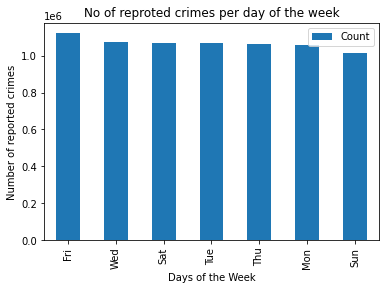

In [ ]:
cp.sort_values('Count', ascending=False).plot(kind='bar', x = 'Day_of_Week', y = 'Count')
plt.xlabel ('Days of the Week')
plt.ylabel('Number of reported crimes')
plt.title('No of reproted crimes per day of the week')

RDD Resilient distribution Datasets

In [ ]:
ps_rdd = sc.textFile('police-station.csv')
ps_rdd.first()

'DISTRICT,DISTRICT NAME,ADDRESS,CITY,STATE,ZIP,WEBSITE,PHONE,FAX,TTY,X COORDINATE,Y COORDINATE,LATITUDE,LONGITUDE,LOCATION'

In [ ]:
ps_header = ps_rdd.first()

In [ ]:
ps_rest = ps_rdd.filter(lambda line: line != ps_header)
ps_rest.first()

'Headquarters,Headquarters,3510 S Michigan Ave,Chicago,IL,60653,http://home.chicagopolice.org,,,,1177731.401,1881697.404,41.83070169,-87.62339535,"(41.8307016873, -87.6233953459)"'

Number of police stations in ps data

In [ ]:
ps_rest.map(lambda line: line.split(',')).count()

24

Dist ID, distict name, address and zip for police station with ID 7

In [ ]:
(ps_rest.filter(lambda line: line.split(',')[0] == '7').
  map(lambda line: (line.split(',')[0],
                    line.split(',')[1],
                    line.split(',')[2],
                    line.split(',')[5]
                    )).collect())

[('7', 'Englewood', '1438 W 63rd St', '60636')]

Police stations 10 and 11. diaplsy ID, name, address, and zip code

In [ ]:
(ps_rest.filter(lambda line: line.split(',')[0] in ['10', '11'] ).
  map(lambda line: (line.split(',')[0],
                    line.split(',')[1],
                    line.split(',')[2],
                    line.split(',')[5]
                    )).collect())

[('10', 'Ogden', '3315 W Ogden Ave', '60623'),
 ('11', 'Harrison', '3151 W Harrison St', '60612')]